In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from operator import itemgetter

%matplotlib notebook 
%matplotlib inline

/home/mercure/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
number_of_jobs = 4 

In [3]:
train_df = pd.read_csv("./Data/train.csv", parse_dates=["Dates"])
test_df = pd.read_csv("./Data/test.csv", parse_dates=["Dates"])

In [4]:
print train_df.shape
print test_df.shape

(878049, 9)
(884262, 7)


In [4]:
# Clean up wrong X and Y values (very few of them)

def scale_coordinates(df):
    xy_scaler = preprocessing.StandardScaler()
    xy_scaler.fit(df[["X","Y"]])
    df[["X","Y"]] = xy_scaler.transform(df[["X","Y"]])
    scaled_df = df[abs(df["Y"])<100]
    scaled_df.index = range(len(scaled_df))
    return scaled_df

In [5]:
train_df = scale_coordinates(train_df)

In [6]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.107902,0.007832
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.107902,0.007832
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.057541,0.064335
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-0.144262,0.065338
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-0.531112,0.001140


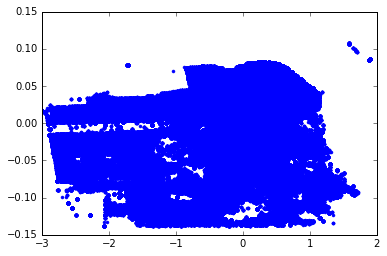

In [7]:
plt.figure()
plt.plot(train_df["X"],train_df["Y"],'.')
plt.show()

In [8]:
def features_scaling(df):
    
    df = scale_coordinates(df)
    feature_list=df.columns.tolist()
    
    if "Dates" in feature_list:
        df["year"] = df["Dates"].dt.year
        df["month"] = df["Dates"].dt.month
        #trainDF["day"] = trainDF["Dates"].dt.day
        df["hour"] = df["Dates"].dt.hour
        feature_list=df.columns.tolist()
        feature_list.remove("Dates")
    if "Category" in feature_list:
        labels = df["Category"].astype('category')
        feature_list.remove("Category")
    else:
        labels=None
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Address" in feature_list:
        feature_list.remove("Address")
    if "Id" in feature_list:
        feature_list.remove("Id")
    
    
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    
    #print cleanData.columns.tolist()
    
    #Creating one-hot variables
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    
    #Droping processed columns
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    feature_list=cleanData.columns.tolist()
    
    #Joining one-hot features
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:])
    
    return features, labels

In [9]:
# Extract year, month and hour

#trainDF["year"] = trainDF["Dates"].dt.year
#trainDF["month"] = trainDF["Dates"].dt.month
#trainDF["day"] = trainDF["Dates"].dt.day
#trainDF["hour"] = trainDF["Dates"].dt.hour
#trainDF.head()

In [10]:
#Remove non feature columns
'''
feature_list=trainDF.columns.tolist()
if "Dates" in feature_list:
    feature_list.remove("Dates")
if "Category" in feature_list:
    feature_list.remove("Category")
if "Descript" in feature_list:
    feature_list.remove("Descript")
if "Resolution" in feature_list:
    feature_list.remove("Resolution")
if "Address" in feature_list:
    feature_list.remove("Address")
if "Id" in feature_list:
    feature_list.remove("Id")
cleanData=trainDF[feature_list]
cleanData.index=range(len(trainDF))
cleanData.head()'''

'\nfeature_list=trainDF.columns.tolist()\nif "Dates" in feature_list:\n    feature_list.remove("Dates")\nif "Category" in feature_list:\n    feature_list.remove("Category")\nif "Descript" in feature_list:\n    feature_list.remove("Descript")\nif "Resolution" in feature_list:\n    feature_list.remove("Resolution")\nif "Address" in feature_list:\n    feature_list.remove("Address")\nif "Id" in feature_list:\n    feature_list.remove("Id")\ncleanData=trainDF[feature_list]\ncleanData.index=range(len(trainDF))\ncleanData.head()'

In [11]:
#Creating one-hot variables
'''dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')

#Droping processed columns
cleanData=cleanData.drop("PdDistrict",axis=1)
cleanData=cleanData.drop("DayOfWeek",axis=1)
#cleanData=cleanData.drop("Address",axis=1)
#cleanData=cleanData.drop("Dates",axis=1)
feature_list=cleanData.columns.tolist()'''

'dummy_ranks_PD = pd.get_dummies(cleanData[\'PdDistrict\'], prefix=\'PD\')\ndummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix=\'DAY\')\n\n#Droping processed columns\ncleanData=cleanData.drop("PdDistrict",axis=1)\ncleanData=cleanData.drop("DayOfWeek",axis=1)\n#cleanData=cleanData.drop("Address",axis=1)\n#cleanData=cleanData.drop("Dates",axis=1)\nfeature_list=cleanData.columns.tolist()'

In [12]:
#Joining one-hot features
#features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:])

In [13]:
features, labels = features_scaling(train_df)

sss = StratifiedShuffleSplit(labels, test_size=0.2, random_state=42)
for train_index, test_index in sss:
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
X_train.index=range(len(X_train))
X_test.index=range(len(X_test))
y_train.index=range(len(y_train))
y_test.index=range(len(y_test))
features.index=range(len(features))
labels.index=range(len(labels))
print X_train.shape
print y_train.shape

(702385, 22)
(702385,)


In [14]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [15]:
'''cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
param_grid = dict()
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, n_jobs=number_of_jobs)
%time grid.fit(features, labels)'''

'cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)\nparam_grid = dict()\ngrid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, n_jobs=number_of_jobs)\n%time grid.fit(features, labels)'

In [16]:
clf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist = {"n_estimators": sp_randint(5, 100), #number of trees in the forest
              "max_depth": sp_randint(5, 20), #maximum depth of the tree
              #"max_features": sp_randint(1, 11),
              #"min_samples_split": sp_randint(1, 11),
              #"min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=cv, n_jobs=number_of_jobs)

In [17]:
#%time random_search.fit(X_train, y_train)
#report(random_search.grid_scores_)

In [18]:
clf_final = RandomForestClassifier(n_estimators=69, bootstrap=True, criterion='entropy', max_depth=19, n_jobs=number_of_jobs)
%time clf_final.fit(X_train, y_train)

CPU times: user 5min 38s, sys: 2.28 s, total: 5min 40s
Wall time: 1min 28s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=19, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
print("test", log_loss(y_test, clf_final.predict_proba(X_test.as_matrix())))

('test', 2.4210280747356094)


In [ ]:
print("train", log_loss(y_train, clf_final.predict_proba(X_train.as_matrix())))

('train', 1.3289501725198882)


In [ ]:
#Very limited interest to compute the line below
#print("all", log_loss(labels, clf_final.predict_proba(features.as_matrix())))